# Build an xarray.Dataset from Scratch

In this `How-To` we'll go through the process of building up an xarray.Dataset that could be used as an input to `Pipeline.calculate`. We'll generate random compositions and fake data to go along with these compositions. 


The dataset generated in this notebook is the basis for the `Building Pipelines` tutorial.

## First Steps

To begin, let's import the necessary libraries for this document and then make an empty :py:class:`xarray.Dataset`

In [ ]:
import numpy as np
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.Dataset()
ds

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

### Compositions

Next, we generate random 'compositions' that we'll do simulated/virtual measurements at. We'll generate the compositions for a 2-dimensional space with components "A" and "B" as placeholders. You could imagine that A and B are the concentrations of two different preservatives in a liquid mixtures. 

In [2]:
num_measurements = 100
A = np.random.uniform(0,10,size=num_measurements)
B = np.random.uniform(0,25,size=num_measurements)
compositions = np.array([A,B]).T
compositions

array([[8.21220622e+00, 2.22370899e+01],
       [9.45219040e+00, 3.73911257e+00],
       [4.32399414e+00, 1.77147594e+01],
       [9.30327053e+00, 2.05615832e+01],
       [1.27779171e-01, 1.79926168e+01],
       [6.66626742e-01, 2.36497541e+01],
       [3.12096044e-01, 2.06068154e+01],
       [6.96323168e+00, 2.01029125e+01],
       [5.91895381e+00, 1.86051352e+01],
       [9.96316021e+00, 1.41799805e+01],
       [5.07789772e+00, 2.82022828e+00],
       [7.25280423e+00, 1.75803875e+01],
       [2.44902048e+00, 1.98325027e+00],
       [2.32107864e+00, 9.65682551e+00],
       [8.10837205e+00, 1.11942815e+01],
       [7.53269048e+00, 2.23320498e+00],
       [1.23874528e+00, 2.11559679e+00],
       [3.05487026e-03, 2.10915212e+01],
       [6.65997075e+00, 2.49973498e+01],
       [4.66441853e+00, 8.53545846e+00],
       [3.89660313e+00, 8.60093938e+00],
       [3.72246031e+00, 2.12565195e+01],
       [6.48558584e+00, 4.21453692e+00],
       [4.06295717e+00, 9.28580307e+00],
       [5.146928

Now let's add this information to the :py:class:`xarray.Dataset`. 

Note how, for the `composition` variable, we need to not only specify the name of the variable in the dataset but also the names of the dimensions of the data ('sample' and 'components').

In [ ]:
ds['compositions'] = (['sample','components'],compositions)
ds['components'] = ('components',['A','B'])
ds


<xarray.Dataset> Size: 2kB
Dimensions:       (sample: 100, components: 2)
Coordinates:
  * components    (components) <U1 8B 'A' 'B'
Dimensions without coordinates: sample
Data variables:
    compositions  (sample, components) float64 2kB 8.212 22.24 ... 6.671 21.97

Okay, in order to simulate a 'phase boundary' we'll create labels for the data. We'll draw an arbitrary line through the composition space and label the data that is above and below that line. 

Let's generate this data and add it to the dataset

In [4]:
labels = (A>(0.25*B-1)).astype(int)
ds['ground_truth_labels'] = ('sample',labels)
ds

<xarray.Dataset> Size: 2kB
Dimensions:              (sample: 100, components: 2)
Coordinates:
  * components           (components) <U1 8B 'A' 'B'
Dimensions without coordinates: sample
Data variables:
    compositions         (sample, components) float64 2kB 8.212 22.24 ... 21.97
    ground_truth_labels  (sample) int64 800B 1 1 1 1 0 0 0 1 ... 1 1 1 1 1 1 0 1

Now we can plot the data. We do this using xarray by first extracting the compositions data variable into a new standalone xarray.Dataset and then calling plot.scatter on it. 

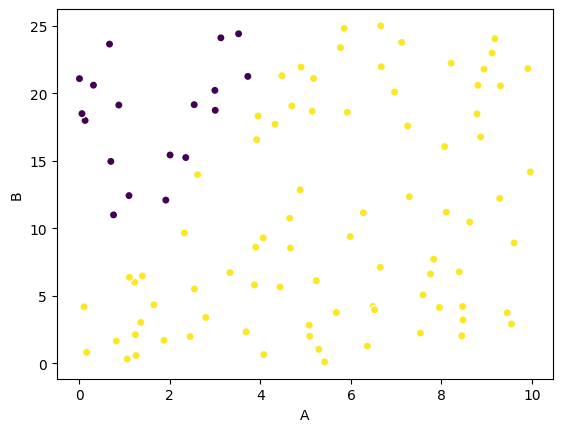

In [5]:
ds.compositions.to_dataset('components').plot.scatter(x='A',y='B',c=ds.ground_truth_labels)

### Simulated Measurement Data

Now let's generate the 'measurement' data. We'll generate one measurement for each composition generated above. We'll generate two kinds of data that depend on the data label:

1. A flat background signal with random Gaussian noise
2. A linear signal with a slope of -4 and random Gaussian noise


In [6]:
#domain of the measurements (e.g., for scattering this would be q, for
#spectroscopy this would be wavelength or wavenumber)
x = np.linspace(0,10,125)

measurements = []
for label in labels:
    if label==0:
        measurements.append(np.random.normal(0, 1.0, x.shape[0]))
    else:
        measurements.append(-4*x + np.random.normal(x, 1.0,x.shape[0]))


# Add the measurement data to the dataset
ds['measurement'] = (['sample','x'],measurements)
ds['x'] = ('x',x)
ds


<xarray.Dataset> Size: 103kB
Dimensions:              (sample: 100, components: 2, x: 125)
Coordinates:
  * components           (components) <U1 8B 'A' 'B'
  * x                    (x) float64 1kB 0.0 0.08065 0.1613 ... 9.839 9.919 10.0
Dimensions without coordinates: sample
Data variables:
    compositions         (sample, components) float64 2kB 8.212 22.24 ... 21.97
    ground_truth_labels  (sample) int64 800B 1 1 1 1 0 0 0 1 ... 1 1 1 1 1 1 0 1
    measurement          (sample, x) float64 100kB 0.5482 -1.506 ... -30.99

Now let's plot the two groups of data

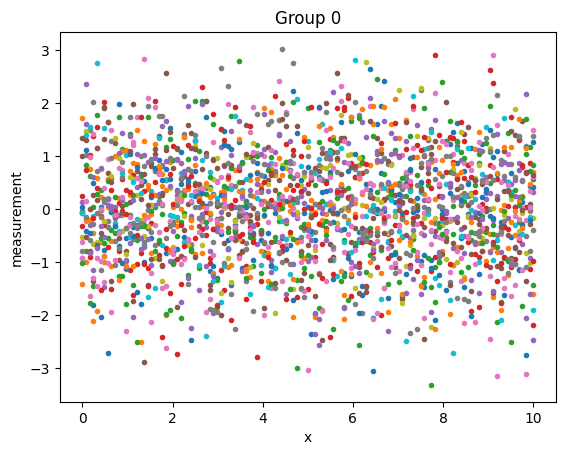

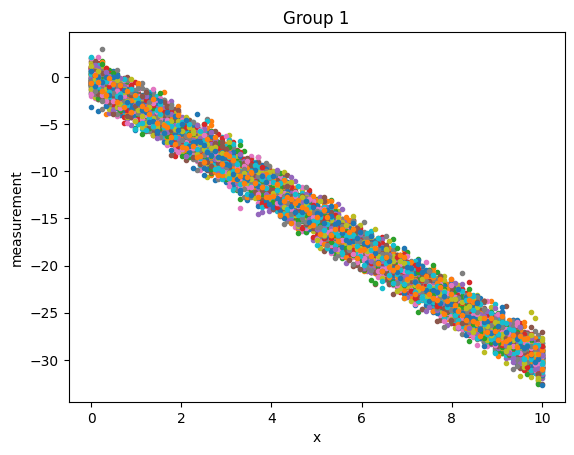

In [7]:
for label, sub_ds in ds.groupby('ground_truth_labels'):
    plt.figure()
    sub_ds.measurement.plot.line(x='x',marker='.',ls='None',add_legend=False)
    plt.title(f'Group {label}')

plt.show()


### Composition Grid

Okay, the final piece of data that you need to start is the composition grid. This grid defines the space that the agent will evaluate when choosing the next composition

In [8]:
num_grid_points = 50
A_grid = np.linspace(0,10,num_grid_points)
B_grid = np.linspace(0,25,num_grid_points)
composition_grid = np.meshgrid(A_grid,B_grid)
composition_grid = np.array([composition_grid[0].ravel(),composition_grid[1].ravel()]).T

ds['composition_grid'] = (['grid','components'],composition_grid)
ds

<xarray.Dataset> Size: 143kB
Dimensions:              (sample: 100, components: 2, x: 125, grid: 2500)
Coordinates:
  * components           (components) <U1 8B 'A' 'B'
  * x                    (x) float64 1kB 0.0 0.08065 0.1613 ... 9.839 9.919 10.0
Dimensions without coordinates: sample, grid
Data variables:
    compositions         (sample, components) float64 2kB 8.212 22.24 ... 21.97
    ground_truth_labels  (sample) int64 800B 1 1 1 1 0 0 0 1 ... 1 1 1 1 1 1 0 1
    measurement          (sample, x) float64 100kB 0.5482 -1.506 ... -30.99
    composition_grid     (grid, components) float64 40kB 0.0 0.0 ... 10.0 25.0

Let's inspect the grid in a plot

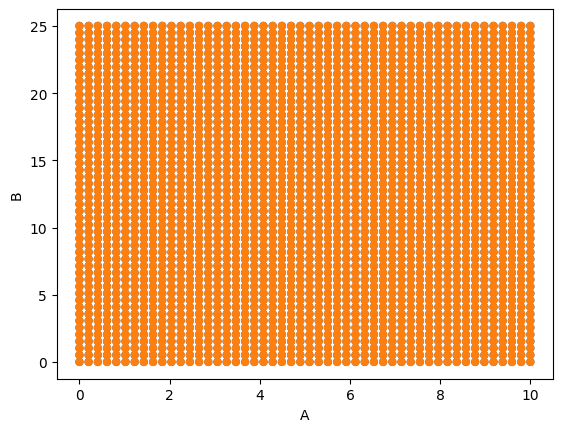

In [10]:
ds.composition_grid.to_dataset('components').plot.scatter(x='A',y='B',edgecolor='None')
plt.show()

## Saving the Dataset to disk

In [12]:

ds.to_netcdf('../data/example_dataset.nc')

## Conclusion